In this notebook, we will work through a Bayes Net analysis using the GES algorithm with the TETRAD software (http://www.phil.cmu.edu/tetrad/).  We will use the same dataset used for the PPI and DCM examples.

In [1]:
import os,sys
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.insert(0,'../')
from utils.mkdesign import create_design_singlecondition
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
from utils.make_data import make_continuous_data
from utils.graph_utils import show_graph_from_adjmtx,show_graph_from_pattern
from statsmodels.tsa.arima_process import arma_generate_sample
import scipy.stats
from dcm_sim import sim_dcm_dataset

results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)


Load the data generated using the DCM forward model. In this model, there is a significant static connectivity from 1->2 and 1->3 (A matrix), and a PPI for 0->2 and 0->4 (B matrix) and a significant input to ROI 0 (C matrix).

In [2]:
_,data_conv,params=sim_dcm_dataset(verbose=True)

A_mtx=params['A']
B_mtx=params['B']
u=params['u']

# downsample design to 1 second TR
u=numpy.convolve(params['u'],spm_hrf(params['stepsize'],oversampling=1))
u=u[range(0,data_conv.shape[0],int(1./params['stepsize']))]
ntp=u.shape[0]




A
[[-1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  1.  0. -1.  0.]
 [ 0.  0.  0.  0. -1.]]
B
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]
C
[[ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


###Generate a set of synthetic datasets, referring to individual subjects

In [3]:
tetrad_dir='/home/vagrant/data/tetrad_files'
if not os.path.exists(tetrad_dir):
    os.mkdir(tetrad_dir)

nfiles=10
for i in range(nfiles):
    _,data_conv,params=sim_dcm_dataset()


    # downsample to 1 second TR
    data=data_conv[range(0,data_conv.shape[0],int(1./params['stepsize']))]
    ntp=data.shape[0]

    imagesdata=numpy.hstack((numpy.array(u)[:,numpy.newaxis],data))
    numpy.savetxt(os.path.join(tetrad_dir,"data%03d.txt"%i),
              imagesdata,delimiter='\t',
             header='u\t0\t1\t2\t3\t4',comments='')

###Run iMAGES (using a shell script)

In [4]:
!bash run_images.sh

Reading in data files...
Aug 15, 2015 6:31:30 PM java.util.prefs.FileSystemPreferences$6 run
Ensuring data sets have same variables in same order...
Replacing columns of 0's with missing value markers (NaN)
Passing data sets to iMAGES with penalty discount of 10.0
Saving DAGs in pattern with maximum score.
Checking output directory...
Outputting XML (recountable) versions of graphs...
Outputting PNG images...
Outputting DOT images...
Done!


###Show the graph estimated by iMAGES

['0', '->', 'u', '[arrowtail=none,', 'arrowhead=none];']
['4', '->', '0', '[arrowtail=none,', 'arrowhead=none];']
['3', '->', '1', '[arrowtail=none,', 'arrowhead=none];']
['1', '->', '2', '[arrowtail=none,', 'arrowhead=normal];']
['u', '->', '2', '[arrowtail=none,', 'arrowhead=normal];']
['}']
Red: unmodulated


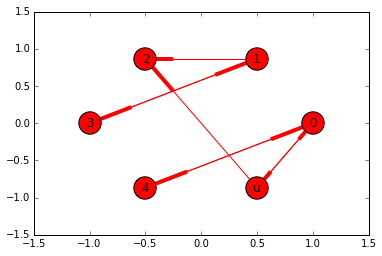

In [5]:
g=show_graph_from_pattern('images_test/test.pattern.dot')

### Show the true graph from the DCM forward model

[(0, 2), (0, 4), (1, 2), (1, 3), ('u', 0)]
Black: input
Red: unmodulated
Blue: modulated


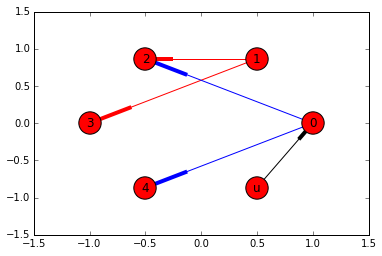

In [6]:
show_graph_from_adjmtx(A_mtx,B_mtx,params['C'])